In [1]:
cd ..

/home/abdalrhman/Desktop/Graduation Project/AiStore/Recommender_V2


In [2]:
import torch
import numpy as np
import pandas as pd
import os
import json
import joblib
import matplotlib.pyplot as plt
import sys 

from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    roc_auc_score, 
    precision_recall_curve, 
    f1_score, 
    precision_score, 
    recall_score, 
    auc
)
from torch_geometric.data import HeteroData
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.nn import SAGEConv, HeteroConv, Linear
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from settings import (
    META_DATA_PATH,
    REVIEWS_DATA_PATH,
    GRAPH_FULL_PATH,
    GRAPH_TRAIN_PATH,
    GRAPH_VAL_PATH,
    GRAPH_TEST_PATH,
    IMAGES_DIR,
    ENCODER_USER,
    ENCODER_ITEM, 
    ENCODER_CATEGORY,
    ENCODER_SCALER,
    MAPPING_USER_T0_ID_PATH,
    MAPPING_ITEM_ASIN_TO_ID_PATH,
    PREDICTOR_MODEL_SAVE_PATH,
    CLEANED_META_DATA_PATH,
    MAPPIN_ID_TO_ASIN_ITEM_PATH, 
    GNN_MODEL_SAVE_PATH,
    ENCODER_BRAND,
    ENCODER_COLOR,
    ITEM_FEATURE_PREPROCESSOR,

)

# Configure paths
NOTEBOOK_DIR = os.getcwd()
PROJECT_ROOT = os.path.abspath(os.path.join(NOTEBOOK_DIR, os.pardir, os.pardir))
sys.path.append(PROJECT_ROOT)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 🧮 1. Data Encoding and Mapping


In [3]:
# Load datasets
meta_df = pd.read_csv(META_DATA_PATH)
reviews_df = pd.read_csv(REVIEWS_DATA_PATH)

# Sample reviews for consistency
reviews_df = reviews_df.sample(n=13000, random_state=42)
filtered_item_ids = reviews_df['parent_asin'].unique()
filtered_meta_df = meta_df[meta_df['parent_asin'].isin(filtered_item_ids)]

# Encode user/item IDs
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

# Encode and map
reviews_df['user_idx'] = user_encoder.fit_transform(reviews_df['user_id'])
reviews_df['item_idx'] = item_encoder.fit_transform(reviews_df['parent_asin'])

# Save encoders
joblib.dump(user_encoder, ENCODER_USER)
joblib.dump(item_encoder, ENCODER_ITEM)

# Build and save mappings
user_id_map = dict(zip(reviews_df['user_id'], reviews_df['user_idx']))
item_id_map = dict(zip(reviews_df['parent_asin'], reviews_df['item_idx']))

# Save user/item mappings
with open(MAPPING_USER_T0_ID_PATH, 'w') as f:
    json.dump({str(k): int(v) for k, v in user_id_map.items()}, f)

with open(MAPPING_ITEM_ASIN_TO_ID_PATH, 'w') as f:
    json.dump({str(k): int(v) for k, v in item_id_map.items()}, f)

# Build reverse mapping
id_to_item = {int(v): k for k, v in item_id_map.items()}
with open(MAPPIN_ID_TO_ASIN_ITEM_PATH, 'w') as f:
    json.dump(id_to_item, f)

In [4]:
# Build and save mappings
user_id_map = dict(zip(reviews_df['user_id'], reviews_df['user_idx']))
item_id_map = dict(zip(reviews_df['parent_asin'], reviews_df['item_idx']))

# Save user/item mappings
with open(MAPPING_USER_T0_ID_PATH, 'w') as f:
    json.dump({str(k): int(v) for k, v in user_id_map.items()}, f)

with open(MAPPING_ITEM_ASIN_TO_ID_PATH, 'w') as f:
    json.dump({str(k): int(v) for k, v in item_id_map.items()}, f)

# Build reverse mapping
id_to_item = {int(v): k for k, v in item_id_map.items()}
with open(MAPPIN_ID_TO_ASIN_ITEM_PATH, 'w') as f:
    json.dump(id_to_item, f)

In [5]:
filtered_meta_df.shape, filtered_item_ids.shape, reviews_df.shape

((801, 15), (10498,), (13000, 13))

In [6]:
filtered_meta_df.head(5)

,main_category,title,average_rating,rating_number,price,store,parent_asin,n_features,n_description_items,first_image,brand,color,date_first_available,primary_category,rating_bin
15,Amazon Fashion,13-15.6 Inch Laptop Sleeve Case Women Men Shou...,4.6,354,14.88,Dealcase,B07DYJR44S,6,16,https://m.media-amazon.com/images/I/41RBgBZC0K...,Unknown,Unknown,2018-06-22,Electronics,High
21,Computers,KHOMO - iPad 2 3 and 4 Generation Case - DUAL ...,4.5,2745,11.95,Khomo,B06XKRXLDR,5,1,https://m.media-amazon.com/images/I/31+mP+y8Uo...,Khomo,Black,2011-05-13,Electronics,Medium
33,Computers,Intel Dual Band Wireless-Ac 8265 w/Bluetooth 8...,4.6,618,20.00,Intel,B01MZA1AB2,4,1,https://m.media-amazon.com/images/I/51DuEWGzGB...,Intel,Brown,2017-01-14,Electronics,High
35,All Electronics,"Charger for MacBook Pro 10FT, 96W USB C Charge...",4.5,2141,35.99,Ifeart,B07WZT643Q,5,0,https://m.media-amazon.com/images/I/21QlbdFXAG...,Ifeart,White,2019-09-23,Electronics,Medium
66,Home Audio & Theater,"C&E High Speed HDMI Cable with Ethernet Black,...",4.6,531,8.99,C&E,B07Q1JN792,5,16,https://m.media-amazon.com/images/I/41IfnleVoM...,C&E,1 Pack,2015-01-21,Electronics,High


# 📦 2. Feature Engineering and Graph Construction

In [7]:
# Define feature groups
numerical_features = ['price', 'average_rating', 'rating_number', 'n_features', 'n_description_items']
categorical_features = ['main_category', 'brand', 'color']

# Build preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numerical_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
        ]), categorical_features)
    ],
    remainder='drop',
    sparse_threshold=0
)

# Fit on available meta_df data
meta_df_clean = meta_df.drop_duplicates('parent_asin')
meta_features = preprocessor.fit_transform(meta_df_clean[numerical_features + categorical_features])
print(f"Raw item features shape: {meta_features.shape}")

# Convert to tensor
if hasattr(meta_features, 'toarray'):
    meta_array = meta_features.toarray()
else:
    meta_array = meta_features

meta_tensor = torch.tensor(meta_array.astype(np.float32), dtype=torch.float32)

# Build full item features
num_items = reviews_df['item_idx'].nunique()  # Should be 960
feature_dim = 64

# Start with zero-initialized features for all items
item_features = torch.zeros(num_items, feature_dim)

# Create projection layer if needed
if meta_tensor.size(1) != feature_dim:
    projection_layer = torch.nn.Linear(meta_tensor.size(1), feature_dim)
    projected_meta = projection_layer(meta_tensor)  # Now [76, 64]
else:
    projected_meta = meta_tensor

# Map meta_df features to item indices
valid_count = 0
for asin, idx in item_id_map.items():
    if asin in meta_df_clean['parent_asin'].values:
        try:
            row_idx = meta_df_clean[meta_df_clean['parent_asin'] == asin].index[0]
            item_features[idx] = projected_meta[row_idx]
            valid_count += 1
        except IndexError:
            continue

print(f"Successfully mapped {valid_count}/{num_items} item features")

Raw item features shape: (13513, 8611)
Successfully mapped 801/10498 item features


In [8]:
# Build edge index
edge_index = torch.tensor([
    reviews_df['user_idx'].values,
    reviews_df['item_idx'].values
], dtype=torch.long)

ratings = torch.tensor(reviews_df['rating'].values, dtype=torch.float)

# Build HeteroData object
data = HeteroData()
data['user'].x = torch.randn(reviews_df['user_idx'].nunique(), feature_dim)
data['item'].x = item_features  # Now shape [960, 64]
data['user', 'rates', 'item'].edge_index = edge_index
data['user', 'rates', 'item'].edge_weight = ratings
data['item', 'rev_rates', 'user'].edge_index = edge_index.flip(0)
data['item', 'rev_rates', 'user'].edge_weight = ratings

print(f"Final item features shape: {data['item'].x.shape}")
print(f"Graph: {data}")

Final item features shape: torch.Size([10498, 64])
Graph: HeteroData(
  user={ x=[12890, 64] },
  item={ x=[10498, 64] },
  (user, rates, item)={
    edge_index=[2, 13000],
    edge_weight=[13000],
  },
  (item, rev_rates, user)={
    edge_index=[2, 13000],
    edge_weight=[13000],
  }
)


/tmp/ipykernel_104529/4206286228.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  edge_index = torch.tensor([


In [9]:
# Must be defined before training
num_items = reviews_df['item_idx'].nunique()  # Should be 960
feature_dim = 64  # Final feature dimension

# Build full item features (ensure all 960 items have features)
item_features = torch.randn(num_items, feature_dim)  # Start with random features

# Replace with real features where available
for asin, idx in item_id_map.items():
    if asin in meta_df['parent_asin'].values:
        try:
            features = meta_df[meta_df['parent_asin'] == asin].iloc[0].values  # Example feature
            item_features[idx] = torch.tensor(features.astype(np.float32))
        except Exception:
            continue

# Assign to graph
data['item'].x = item_features.to(device)

# 🔀 3. Graph Splitting and Saving

In [10]:
# Apply RandomLinkSplit
transform = RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    is_undirected=True,
    add_negative_train_samples=False,
    edge_types=[('user', 'rates', 'item')],
    rev_edge_types=[('item', 'rev_rates', 'user')]
)

train_data, val_data, test_data = transform(data)

# Save graphs
torch.save(data, GRAPH_FULL_PATH)
torch.save(train_data, GRAPH_TRAIN_PATH)
torch.save(val_data, GRAPH_VAL_PATH)
torch.save(test_data, GRAPH_TEST_PATH)

print("Graphs saved successfully.")

Graphs saved successfully.


# 🧱 4. Model Definition

In [11]:
class HeteroGraphSAGE(nn.Module):
    def __init__(self, hidden_dim=128):
        super().__init__()
        self.conv1 = HeteroConv({
            ('user', 'rates', 'item'): SAGEConv((-1, -1), hidden_dim),
            ('item', 'rev_rates', 'user'): SAGEConv((-1, -1), hidden_dim)
        }, aggr='mean')
        
        self.conv2 = HeteroConv({
            ('user', 'rates', 'item'): SAGEConv(hidden_dim, hidden_dim),
            ('item', 'rev_rates', 'user'): SAGEConv(hidden_dim, hidden_dim)
        }, aggr='mean')
        
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x_dict, edge_index_dict):
        # First conv layer
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {key: self.bn1(x) for key, x in x_dict.items()}
        x_dict = {key: F.leaky_relu(x) for key, x in x_dict.items()}
        x_dict = {key: self.dropout(x) for key, x in x_dict.items()}
        
        # Second conv layer
        x_dict = self.conv2(x_dict, edge_index_dict)
        x_dict = {key: self.bn2(x) for key, x in x_dict.items()}
        return x_dict

class LinkPredictor(nn.Module):
    def __init__(self, hidden_dim=128):
        super().__init__()
        self.mlp = nn.Sequential(
            Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            Linear(hidden_dim, 1)
        )

    def forward(self, src, dst):
        return self.mlp(torch.cat([src, dst], dim=-1)).squeeze()

# 🔧 5. Training Setup

In [12]:
# Move data to device
train_data, val_data, test_data = [d.to(device) for d in [train_data, val_data, test_data]]

# Initialize models
gnn = HeteroGraphSAGE(hidden_dim=128).to(device)
predictor = LinkPredictor(hidden_dim=128).to(device)

# Optimizer and scheduler
optimizer = optim.AdamW([
    {'params': gnn.parameters(), 'lr': 1e-3},
    {'params': predictor.parameters(), 'lr': 5e-4}
], weight_decay=1e-5)

scheduler = ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=5, verbose=True
)

# Load item_id_map for negative sampling
def load_mapping(path):
    with open(path, 'r') as f:
        return json.load(f)

item_id_map = load_mapping(MAPPING_ITEM_ASIN_TO_ID_PATH)
num_items = len(item_id_map)  # 960

/home/abdalrhman/Desktop/Graduation Project/AiStore/venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


# 🧪 6. Training Functions

In [13]:
def train_epoch(data, neg_ratio=5):
    gnn.train()
    predictor.train()
    optimizer.zero_grad()

    # Forward pass
    emb = gnn(data.x_dict, data.edge_index_dict)

    # Get positive edges
    edge_index = data['user', 'rates', 'item'].edge_index
    src, dst = edge_index[0], edge_index[1]
    pos_pred = predictor(emb['user'][src], emb['item'][dst])

    # Generate negatives safely
    neg_src, neg_dst = [], []
    for u in src.unique().cpu().tolist():
        seen = dst[src == u]
        candidates = torch.randint(0, num_items, (len(seen)*neg_ratio,), device=device)
        valid = ~torch.isin(candidates, seen)
        sampled = candidates[valid][:len(seen)]
        if len(sampled) > 0:
            neg_src.append(torch.tensor([u]*len(sampled), device=device))
            neg_dst.append(sampled)

    if not neg_src:
        return 0.0

    # Get negative predictions
    neg_pred = predictor(
        emb['user'][torch.cat(neg_src)],
        emb['item'][torch.cat(neg_dst)]
    )

    # Combine and compute loss
    loss = F.binary_cross_entropy_with_logits(
        torch.cat([pos_pred, neg_pred]),
        torch.cat([
            torch.ones_like(pos_pred),
            torch.zeros_like(neg_pred)
        ])
    )

    # Backward pass
    loss.backward()
    optimizer.step()
    return loss.item()

In [14]:
@torch.no_grad()
def evaluate(data):
    gnn.eval()
    predictor.eval()
    
    # Forward pass
    emb = gnn(data.x_dict, data.edge_index_dict)
    
    # Positive predictions
    edge_index = data['user', 'rates', 'item'].edge_index
    src, dst = edge_index[0], edge_index[1]
    pos_pred = predictor(emb['user'][src], emb['item'][dst])
    pos_labels = torch.ones(len(pos_pred))

    # Negative sampling
    neg_src, neg_dst = [], []
    for u in src.unique().cpu().tolist():
        seen = dst[src == u]
        candidates = torch.randint(0, num_items, (len(seen)*5,), device=seen.device)
        valid = ~torch.isin(candidates, seen)
        sampled = candidates[valid][:len(seen)]
        if len(sampled) > 0:
            neg_src.append(torch.tensor([u]*len(sampled), device=device))
            neg_dst.append(sampled)

    if not neg_src:
        return {
            'auc': 0.5, 'f1': 0.0,
            'precision': 0.0, 'recall': 0.0,
            'threshold': 0.5
        }

    # Get negative predictions
    neg_pred = predictor(
        emb['user'][torch.cat(neg_src)],
        emb['item'][torch.cat(neg_dst)]
    )
    neg_labels = torch.zeros(len(neg_pred))

    # Combine and compute metrics
    scores = torch.cat([pos_pred, neg_pred]).cpu().numpy()
    labels = torch.cat([pos_labels, neg_labels]).cpu().numpy()

    # AUC and thresholding
    auc = roc_auc_score(labels, scores)
    precisions, recalls, thresholds = precision_recall_curve(labels, scores)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
    best_idx = np.argmax(f1_scores)

    return {
        'auc': auc,
        'precision': precisions[best_idx],
        'recall': recalls[best_idx],
        'f1': f1_scores[best_idx],
        'threshold': thresholds[best_idx]
    }

# 🚀 7. Model Training with Early Stopping

In [15]:
# Initialize tracking
epochs_list = []
losses_list = []
aucs_list = []
f1s_list = []
precisions_list = []
recalls_list = []
thresholds_list = []

best_f1 = 0.0
patience = 0
epoches = 50
# Training loop
for epoch in range(1, epoches + 1):
    loss = train_epoch(train_data)
    val_metrics = evaluate(val_data)
    scheduler.step(val_metrics['f1'])
    
    # Log metrics
    epochs_list.append(epoch)
    losses_list.append(loss)
    aucs_list.append(val_metrics['auc'])
    f1s_list.append(val_metrics['f1'])
    precisions_list.append(val_metrics['precision'])
    recalls_list.append(val_metrics['recall'])
    thresholds_list.append(val_metrics['threshold'])
    
    # Print metrics
    print(f"Epoch {epoch:03d} | Loss: {loss:.4f} | "
          f"Val AUC: {val_metrics['auc']:.4f} | F1: {val_metrics['f1']:.4f} | "
          f"Prec: {val_metrics['precision']:.4f} | Rec: {val_metrics['recall']:.4f} | "
          f"Threshold: {val_metrics['threshold']:.4f}")
    
    # Early stopping
    if val_metrics['f1'] > best_f1:
        best_f1 = val_metrics['f1']
        torch.save(gnn.state_dict(), GNN_MODEL_SAVE_PATH)
        torch.save(predictor.state_dict(), PREDICTOR_MODEL_SAVE_PATH)
        patience = 0
    else:
        patience += 1
        if patience >= 20:
            print("Early stopping triggered.")
            break

Epoch 001 | Loss: 0.6975 | Val AUC: 0.6011 | F1: 0.6719 | Prec: 0.5159 | Rec: 0.9628 | Threshold: 0.0107
Epoch 002 | Loss: 0.6856 | Val AUC: 0.6675 | F1: 0.7007 | Prec: 0.5712 | Rec: 0.9062 | Threshold: 0.1288
Epoch 003 | Loss: 0.6749 | Val AUC: 0.7152 | F1: 0.7224 | Prec: 0.5797 | Rec: 0.9585 | Threshold: 0.1754
Epoch 004 | Loss: 0.6629 | Val AUC: 0.7407 | F1: 0.7309 | Prec: 0.5980 | Rec: 0.9396 | Threshold: 0.2562
Epoch 005 | Loss: 0.6533 | Val AUC: 0.7616 | F1: 0.7405 | Prec: 0.6206 | Rec: 0.9176 | Threshold: 0.3332
Epoch 006 | Loss: 0.6419 | Val AUC: 0.7697 | F1: 0.7418 | Prec: 0.6263 | Rec: 0.9096 | Threshold: 0.3964
Epoch 007 | Loss: 0.6333 | Val AUC: 0.7867 | F1: 0.7518 | Prec: 0.6357 | Rec: 0.9197 | Threshold: 0.4431
Epoch 008 | Loss: 0.6221 | Val AUC: 0.7975 | F1: 0.7561 | Prec: 0.6470 | Rec: 0.9096 | Threshold: 0.4979
Epoch 009 | Loss: 0.6136 | Val AUC: 0.8076 | F1: 0.7632 | Prec: 0.6534 | Rec: 0.9173 | Threshold: 0.5327
Epoch 010 | Loss: 0.6048 | Val AUC: 0.8187 | F1: 0.7699

# 📊 8. Model Evaluation and Visualization

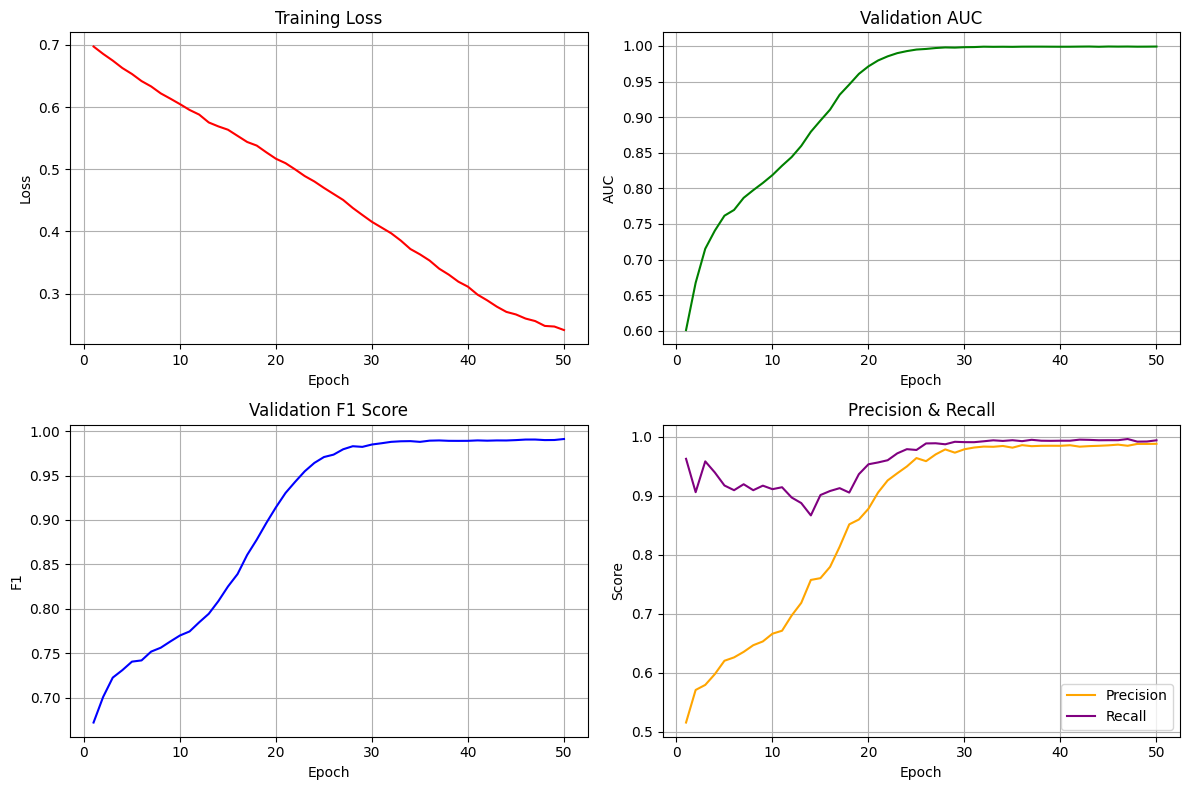

In [16]:
import matplotlib.pyplot as plt

# Plot training metrics
plt.figure(figsize=(12, 8))

# Loss
plt.subplot(2, 2, 1)
plt.plot(epochs_list, losses_list, label="Train Loss", color='red')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

# AUC
plt.subplot(2, 2, 2)
plt.plot(epochs_list, aucs_list, label="Val AUC", color='green')
plt.title("Validation AUC")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.grid(True)

# F1 Score
plt.subplot(2, 2, 3)
plt.plot(epochs_list, f1s_list, label="Val F1", color='blue')
plt.title("Validation F1 Score")
plt.xlabel("Epoch")
plt.ylabel("F1")
plt.grid(True)

# Precision & Recall
plt.subplot(2, 2, 4)
plt.plot(epochs_list, precisions_list, label="Precision", color='orange')
plt.plot(epochs_list, recalls_list, label="Recall", color='purple')
plt.title("Precision & Recall")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig(IMAGES_DIR)
plt.savefig(os.path.join(IMAGES_DIR, 'model_evaluation.png'))
plt.show()


Test Metrics:
AUC: 0.9986 | F1: 0.9886
Precision: 0.9835 | Recall: 0.9937
Threshold: 0.2139


<Figure size 800x600 with 0 Axes>

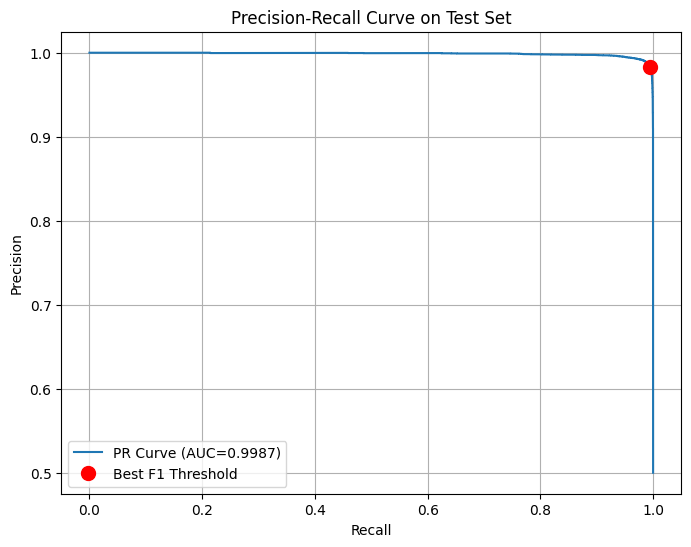

Final Test Results: {'auc': np.float64(0.9986218934911242), 'precision': np.float64(0.9835039336773539), 'recall': np.float64(0.9936752136752137), 'f1': np.float64(0.988563406419715), 'threshold': np.float32(0.21389852)}


In [17]:
@torch.no_grad()
def test_model():
    gnn.load_state_dict(torch.load(GNN_MODEL_SAVE_PATH, map_location=device))
    predictor.load_state_dict(torch.load(PREDICTOR_MODEL_SAVE_PATH, map_location=device))
    test_metrics = evaluate(test_data)
    
    print("\nTest Metrics:")
    print(f"AUC: {test_metrics['auc']:.4f} | F1: {test_metrics['f1']:.4f}")
    print(f"Precision: {test_metrics['precision']:.4f} | Recall: {test_metrics['recall']:.4f}")
    print(f"Threshold: {test_metrics['threshold']:.4f}")
    
    # Plot PR Curve
    plt.figure(figsize=(8, 6))
    emb = gnn(test_data.x_dict, test_data.edge_index_dict)
    edge_index = test_data['user', 'rates', 'item'].edge_index
    pos_pred = predictor(emb['user'][edge_index[0]], emb['item'][edge_index[1]])
    pos_labels = torch.ones(len(pos_pred))
    
    neg_src, neg_dst = [], []
    for u in edge_index[0].unique().cpu().tolist():
        seen = edge_index[1][edge_index[0] == u]
        candidates = torch.randint(0, num_items, (len(seen)*5,), device=seen.device)
        valid = ~torch.isin(candidates, seen)
        sampled = candidates[valid][:len(seen)]
        if len(sampled) > 0:
            neg_src.append(torch.tensor([u]*len(sampled), device=device))
            neg_dst.append(sampled)
    
    if neg_src:
        neg_pred = predictor(
            emb['user'][torch.cat(neg_src)],
            emb['item'][torch.cat(neg_dst)]
        )
        neg_labels = torch.zeros(len(neg_pred))
        scores = torch.cat([pos_pred, neg_pred]).cpu().numpy()
        labels = torch.cat([pos_labels, neg_labels]).cpu().numpy()
        
        # PR Curve
        precisions, recalls, thresholds = precision_recall_curve(labels, scores)
        f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
        best_idx = np.argmax(f1_scores)
        
        # Plot
        plt.figure(figsize=(8, 6))
        plt.plot(recalls, precisions, label=f'PR Curve (AUC={auc(recalls, precisions):.4f})')
        plt.plot([test_metrics['recall']], [test_metrics['precision']], 
                'ro', markersize=10, label='Best F1 Threshold')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title("Precision-Recall Curve on Test Set")
        plt.legend()
        plt.grid(True)
        plt.savefig(os.path.join(IMAGES_DIR, 'pr_curve_test.png'))
        plt.show()
    
    return test_metrics

# Run final evaluation
test_results = test_model()
print(f"Final Test Results: {test_results}")

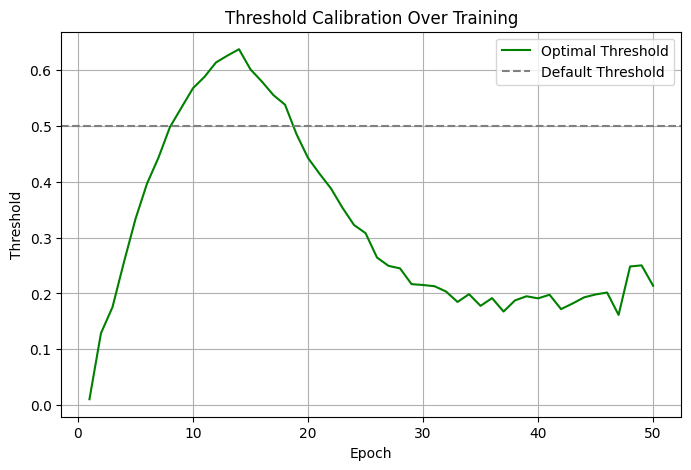

In [18]:
# Plot threshold evolution
plt.figure(figsize=(8, 5))
plt.plot(epochs_list, thresholds_list, label="Optimal Threshold", color='green')
plt.axhline(y=0.5, color='gray', linestyle='--', label="Default Threshold")
plt.title("Threshold Calibration Over Training")
plt.xlabel("Epoch")
plt.ylabel("Threshold")
plt.legend()
plt.grid(True)
plt.savefig(IMAGES_DIR)
plt.savefig(os.path.join(IMAGES_DIR, 'threhold_plot.png'))
plt.show()

In [19]:
# Save models
torch.save(gnn.state_dict(), GNN_MODEL_SAVE_PATH)
torch.save(predictor.state_dict(), PREDICTOR_MODEL_SAVE_PATH)

# Save preprocessor and feature encoders
cat_encoder = preprocessor.named_transformers_['cat'].named_steps['encoder']
num_scaler = preprocessor.named_transformers_['num'].named_steps['scaler']
joblib.dump(cat_encoder, ENCODER_CATEGORY)
joblib.dump(num_scaler, ENCODER_SCALER)
joblib.dump(meta_df_clean, CLEANED_META_DATA_PATH)

['/home/abdalrhman/Desktop/Graduation Project/AiStore/Recommender_V2/artifacts/meta_df_clean.pkl']

In [20]:
data

HeteroData(
  user={ x=[12890, 64] },
  item={ x=[10498, 64] },
  (user, rates, item)={
    edge_index=[2, 13000],
    edge_weight=[13000],
  },
  (item, rev_rates, user)={
    edge_index=[2, 13000],
    edge_weight=[13000],
  }
)

In [21]:
train_data

HeteroData(
  user={ x=[12890, 64] },
  item={ x=[10498, 64] },
  (user, rates, item)={
    edge_index=[2, 10400],
    edge_weight=[10400],
    edge_label=[10400],
    edge_label_index=[2, 10400],
  },
  (item, rev_rates, user)={
    edge_index=[2, 10400],
    edge_weight=[10400],
  }
)

In [22]:
val_data

HeteroData(
  user={ x=[12890, 64] },
  item={ x=[10498, 64] },
  (user, rates, item)={
    edge_index=[2, 10400],
    edge_weight=[10400],
    edge_label=[2600],
    edge_label_index=[2, 2600],
  },
  (item, rev_rates, user)={
    edge_index=[2, 10400],
    edge_weight=[10400],
  }
)

In [23]:
test_data

HeteroData(
  user={ x=[12890, 64] },
  item={ x=[10498, 64] },
  (user, rates, item)={
    edge_index=[2, 11700],
    edge_weight=[11700],
    edge_label=[2600],
    edge_label_index=[2, 2600],
  },
  (item, rev_rates, user)={
    edge_index=[2, 11700],
    edge_weight=[11700],
  }
)

# ✅ Final Recommender Function with Real ASINs

In [24]:
def load_mappings():
    # Verify files exist
    for path in [MAPPING_USER_T0_ID_PATH, MAPPING_ITEM_ASIN_TO_ID_PATH, REVERSED_MAPPING_ITEM]:
        if not os.path.exists(path):
            raise FileNotFoundError(f"Mapping file not found: {path}")
    
    # Load mappings
    with open(MAPPING_USER_T0_ID_PATH, 'r') as f:
        user_id_map = json.load(f)
    
    with open(MAPPING_ITEM_ASIN_TO_ID_PATH, 'r') as f:
        item_id_map = json.load(f)
    
    with open(MAPPIN_ID_TO_ASIN_ITEM_PATH, 'r') as f:
        id_to_item = json.load(f)
    
    # Convert keys to correct types
    return {
        'user_id_map': {str(k): int(v) for k, v in user_id_map.items()},
        'item_id_map': {str(k): int(v) for k, v in item_id_map.items()},
        'id_to_item': {int(k): str(v) for k, v in id_to_item.items()}
    }

# Load mappings
mappings = load_mappings()
user_id_map = mappings['user_id_map']
item_id_map = mappings['item_id_map']
id_to_item = mappings['id_to_item']
user_id_map

NameError: name 'REVERSED_MAPPING_ITEM' is not defined

In [ ]:
# Load full graph
full_data = torch.load(GRAPH_FULL_PATH, weights_only=False, map_location=device)

# Load trained models
gnn = HeteroGraphSAGE(hidden_dim=128).to(device)
predictor = LinkPredictor(hidden_dim=128).to(device)

gnn.load_state_dict(torch.load(GNN_MODEL_SAVE_PATH, map_location=device))
predictor.load_state_dict(torch.load(PREDICTOR_MODEL_SAVE_PATH, map_location=device))

In [ ]:
@torch.no_grad()
def recommend_top_k(user_id, k=5):
    """
    Recommend top-k products for a given user ID
    
    Args:
        user_id (str): Original user ID
        k (int): Number of recommendations
    
    Returns:
        list: List of recommended ASINs
    """
    gnn.eval()
    predictor.eval()

    # Validate user exists
    if user_id not in user_id_map:
        raise ValueError(f"User '{user_id}' not found in mapping")
    
    user_idx = int(user_id_map[user_id])  # Convert user_id → model index
    
    # Get embeddings
    emb = gnn(full_data.x_dict, full_data.edge_index_dict)
    
    # Get user embedding and expand for all items
    user_emb = emb['user'][user_idx].unsqueeze(0)
    item_embs = emb['item']
    
    # Predict scores
    scores = predictor(user_emb.expand(item_embs.size(0), -1), item_embs).cpu().numpy()
    
    # Exclude already interacted items
    edge_index = full_data['user', 'rates', 'item'].edge_index
    interacted_items = edge_index[1][edge_index[0] == user_idx].cpu().numpy()
    scores[interacted_items] = -np.inf
    
    # Get top-k item indices
    top_k_indices = np.argpartition(scores, -k)[-k:]
    top_k_scores = scores[top_k_indices]
    top_k_indices = top_k_indices[np.argsort(-top_k_scores)]
    
    # Map to ASINs
    return [id_to_item.get(int(i), None) for i in top_k_indices]

# 📦 Example Usage

In [ ]:
try:
    recommendations = recommend_top_k('AFCO6LEANZBTDWKI4BH6BO7H4PIA', k=5)
    print("Recommended ASINs:", recommendations)
except ValueError as e:
    print(e)

In [ ]:
def recommend_with_metadata(user_id, k=5):
    recommended = recommend_top_k(user_id, k=k)
    return meta_df[meta_df['parent_asin'].isin(recommended)][[
        'parent_asin', 'title', 'price', 'average_rating', 'main_category'
    ]].to_dict(orient='records')

In [ ]:
recommended = recommend_top_k('AFCO6LEANZBTDWKI4BH6BO7H4PIA', k=1000)
print("Raw Recommended ASINs:", recommended)

# ✅ Load `meta_df_clean`

In [ ]:
# Load original meta_df
meta_df = pd.read_csv(META_DATA_PATH)

# Reapply filtering and deduplication
filtered_item_ids = reviews_df['parent_asin'].unique()
meta_df_clean = meta_df[meta_df['parent_asin'].isin(filtered_item_ids)].drop_duplicates('parent_asin')

# Save as CSV (recommended for safety)
# meta_df_clean.to_csv(CLEANED_META_DATA_PATH, index=False)

# Or save as pickle (ensure binary mode)
meta_df_clean.to_pickle(CLEANED_META_DATA_PATH)
loaded_meta_df_clean = pd.read_pickle(CLEANED_META_DATA_PATH)
loaded_meta_df_clean

In [ ]:
# Only keep ASINs that exist in meta_df_clean
valid_recommended = [asin for asin in recommended if asin in meta_df_clean['parent_asin'].values]

print(f"Valid ASINs found in meta_df_clean: {valid_recommended}")

In [ ]:
# Filter meta_df_clean to only include valid ASINs
recommended_products = loaded_meta_df_clean[loaded_meta_df_clean['parent_asin'].isin(valid_recommended)]

# Add a custom sort order based on original recommendation
recommended_products['asin_order'] = pd.Categorical(
    recommended_products['parent_asin'], 
    categories=valid_recommended,
    ordered=True
)

# Sort by recommendation order
recommended_products = recommended_products.sort_values('asin_order').drop('asin_order', axis=1)

In [ ]:
# Show important product info
recommended_products[[
    'parent_asin', 'title', 'price', 'average_rating', 
    'main_category', 'brand', 'color'
]]

In [ ]:
product_list = recommended_products.to_dict(orient='records')

for p in product_list:
    print(f"ASIN: {p['parent_asin']}")
    print(f"Title: {p['title']}")
    print(f"Price: ${p['price']}")
    print(f"Rating: {p['average_rating']} ({p['rating_number']} reviews)")
    print(f"Category: {p['main_category']}")
    print(f"Brand: {p['brand']}")
    print("-" * 40)

In [ ]:
def get_recommended_products(recommended, meta_df_clean):
    """
    Safely filter and reorder meta_df_clean based on recommended ASINs.
    
    Args:
        recommended (list): List of ASINs from recommendation system
        meta_df_clean (pd.DataFrame): Cleaned metadata with item features
    
    Returns:
        pd.DataFrame: Filtered and ordered DataFrame with product details
    """
    # Step 1: Filter only valid ASINs that exist in meta_df_clean
    valid_recommended = [asin for asin in recommended if asin in meta_df_clean['parent_asin'].values]
    
    # Step 2: Filter meta_df_clean for matching ASINs
    filtered = meta_df_clean[meta_df_clean['parent_asin'].isin(valid_recommended)]
    
    # Step 3: Reorder to match recommendation order
    filtered['asin_order'] = pd.Categorical(
        filtered['parent_asin'], 
        categories=valid_recommended,
        ordered=True
    )
    return filtered.sort_values('asin_order').drop('asin_order', axis=1)

# Example usage
recommended_products = get_recommended_products(recommended, loaded_meta_df_clean)
recommended_products[['parent_asin', 'title', 'price', 'average_rating', 'main_category']]